In [1]:
import os, sys, time

from pathlib import Path
import pickle 
import json 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import xgboost as xgb
# import shap
# from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from scipy.stats import entropy
from itertools import combinations
from sklearn.metrics import mutual_info_score, confusion_matrix

In [173]:
cell_types = ['L23_IT_CTX_Glut','L5_ET_CTX_Glut','L6_IT_CTX_Glut','L6_CT_CTX_Glut','CA3_Glut','CA1-ProS_Glut','DG_Glut','Astro-TE_NN','Oligo_NN','OPC_NN','Pvalb_Gaba',]

In [4]:
def information_gain(labels, preds): 
    start_entropy = entropy(pd.DataFrame(labels).value_counts(), base=2)
    ccf = confusion_matrix(labels, preds)
    conditional_entropy = (entropy(ccf, base=2, axis=0) * (ccf.sum(axis=0) / ccf.sum())).sum()
    return start_entropy - conditional_entropy 

def jaccard_similarity(set_1, set_2): 
    inter = len(set_1.intersection(set_2))
    union = len(set_1.union(set_2))
    return inter / union

In [5]:
def read_json(_ct, _epoch): 
    with open(f'../train_models/xgb_logging/{_ct}.epoch_{_epoch}.json', 'r') as fp: 
        res_dict = json.load(fp)

    y_test_labels = res_dict['y_test_labels']
    y_test_preds = res_dict['y_test_preds']
    y_train_labels = res_dict['y_train_labels']
    y_train_preds = res_dict['y_train_preds']
    cols_to_keep = set(res_dict['cols_to_keep'])
    
    return (y_test_labels, y_test_preds, y_train_labels, y_train_preds, cols_to_keep)    

In [6]:
def jaccard_corr_matrix(samples): 
    n_samples = len(samples)
    corr = np.zeros((n_samples,n_samples), dtype=np.float64)
    for i in range(n_samples): 
        for j in range(n_samples): 
            corr[i][j] = jaccard_similarity(samples[i], samples[j])
    return corr

In [188]:
def generate_rank_corr_matrix(cell_types:list, col:str='rank', num_downsample:int|None = None):
    """
    Separate out Results into their up / down / up
    cell_types - the cell types to do this for
    col - the column to extrac (rank / abs_mean_shap)
    """
    df_down = pd.DataFrame()
    df_non = pd.DataFrame()
    df_up = pd.DataFrame()
    for i, _ct in enumerate(cell_types):
        df_rank = pd.read_csv(f'../train_models/xgb_logging/{_ct}.shap_rank.csv', index_col='index')
        
        if num_downsample is not None: 
            samp_rank = pd.DataFrame(df_rank.loc[df_rank[f'rank.down'] < num_downsample, f'{col}.down'])
            samp_rank = samp_rank.merge(df_rank.loc[df_rank[f'rank.non'] < num_downsample, f'{col}.non'], left_on='index', right_on = 'index', how='outer')
            samp_rank = samp_rank.merge(df_rank.loc[df_rank[f'rank.up'] < num_downsample, f'{col}.up'], left_on='index', right_on = 'index', how='outer')
            df_rank = samp_rank.copy()
            del samp_rank
    
        if i == 0: 
            df_down[_ct] = df_rank[f'{col}.down']
            df_non[_ct] = df_rank[f'{col}.non']
            df_up[_ct] = df_rank[f'{col}.up']
        else: 
            df_down = df_down.merge(df_rank[f'{col}.down'], left_on='index', right_on='index', how='outer')
            df_down[_ct] = df_down[f'{col}.down'] 
            df_down = df_down.drop(columns = [f'{col}.down'])
    
            df_non = df_non.merge(df_rank[f'{col}.non'], left_on='index', right_on='index', how='outer')
            df_non[_ct] = df_non[f'{col}.non'] 
            df_non = df_non.drop(columns = [f'{col}.non'])
    
            df_up = df_up.merge(df_rank[f'{col}.up'], left_on='index', right_on='index', how='outer')
            df_up[_ct] = df_up[f'{col}.up'] 
            df_up = df_up.drop(columns = [f'{col}.up'])    
    return (df_down, df_non, df_up)

def generate_mod_corr_matrix(cell_types:list, num_downsample:int|None = None):
    """
    Separate out Results into their up / down / up
    cell_types - the cell types to do this for
    col - the column to extrac (rank / abs_mean_shap)
    """
    df_down = pd.DataFrame()
    df_non = pd.DataFrame()
    df_up = pd.DataFrame()
    for i, _ct in enumerate(cell_types):
        df_rank = pd.read_csv(f'../train_models/xgb_logging/{_ct}.shap_rank.csv', index_col='index')
        
        if num_downsample is not None: 
            samp_rank = pd.DataFrame(df_rank.loc[df_rank[f'rank.down'] < num_downsample, f'rank.down'])
            samp_rank = samp_rank.merge(df_rank.loc[df_rank[f'rank.non'] < num_downsample, f'rank.non'], left_on='index', right_on = 'index', how='outer')
            samp_rank = samp_rank.merge(df_rank.loc[df_rank[f'rank.up'] < num_downsample, f'rank.up'], left_on='index', right_on = 'index', how='outer')
            df_rank = samp_rank.copy()
            del samp_rank

        mod_split = [x.split('.')[-1] for x in df_rank.index]
        if i == 0: 
            df_counts = pd.DataFrame(pd.DataFrame(mod_split).value_counts())
            df_counts.columns = [_ct]
        else: 
            df_counts[_ct] = pd.DataFrame(mod_split).value_counts()
    
    return df_counts

In [124]:
df_down, df_non, df_up = generate_rank_corr_matrix(cell_types, col='rank', num_downsample=50)

In [170]:
df_mod = generate_mod_corr_matrix(cell_types, num_downsample=10)

<Axes: >

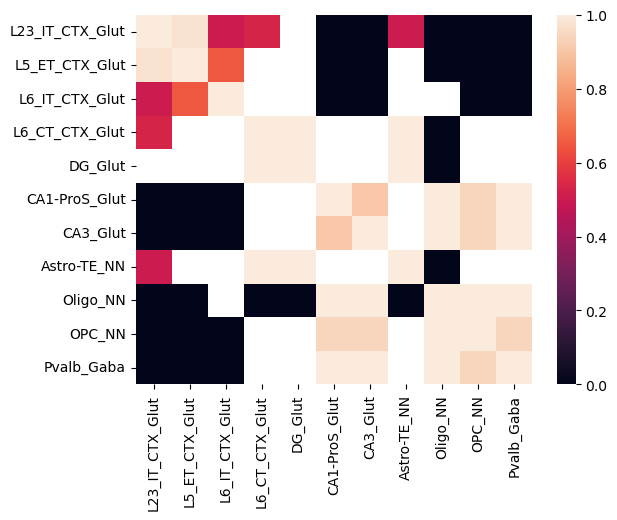

In [171]:
sns.heatmap(df_mod.corr(), vmin=0, vmax=1)

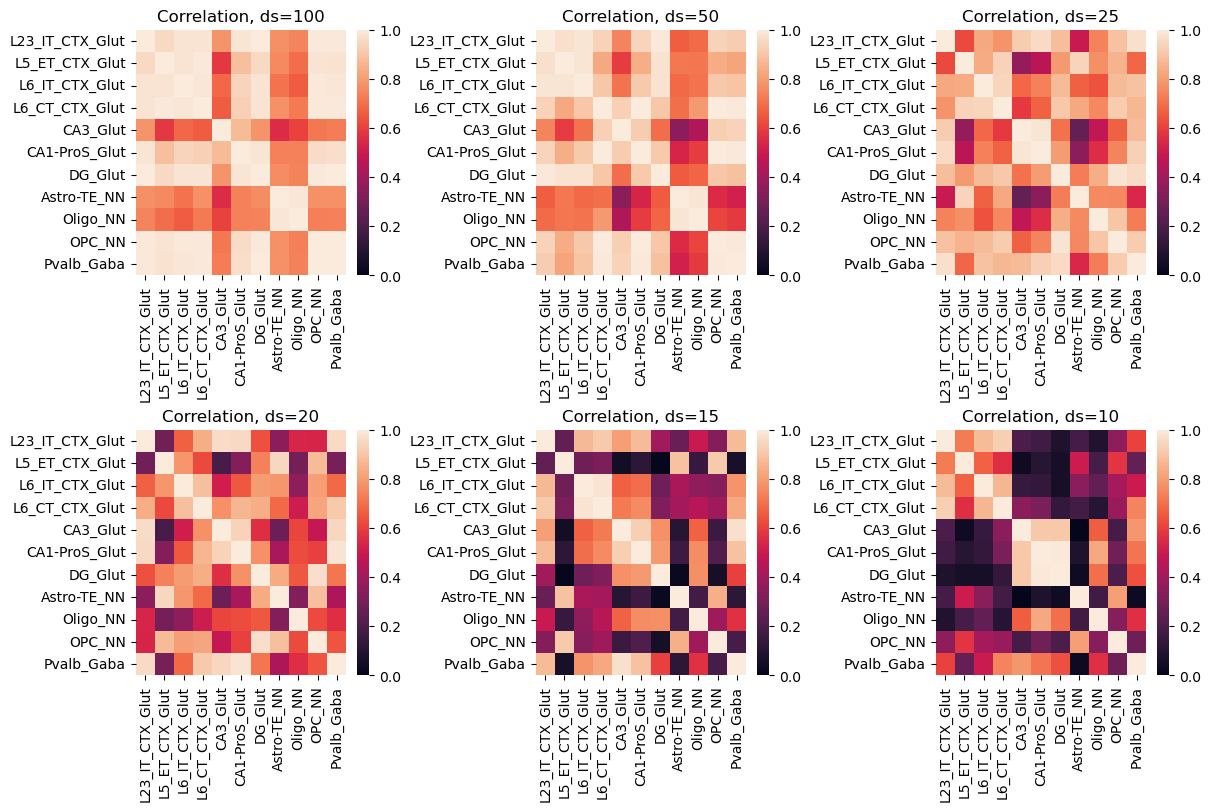

In [195]:
ds_range = [100, 50, 25, 20, 15, 10]
fig, axes = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)
for i, ds in enumerate(ds_range): 
    df_mod = generate_mod_corr_matrix(cell_types, num_downsample=ds)
    
    tt = df_mod.corr().values
    tt = np.power(tt, 3)
    sns.heatmap(tt, vmin=0, vmax=1, xticklabels=cell_types, yticklabels=cell_types, ax=axes.flatten()[i])
    axes.flatten()[i].set_title(f"Correlation, ds={ds}")

plt.show()

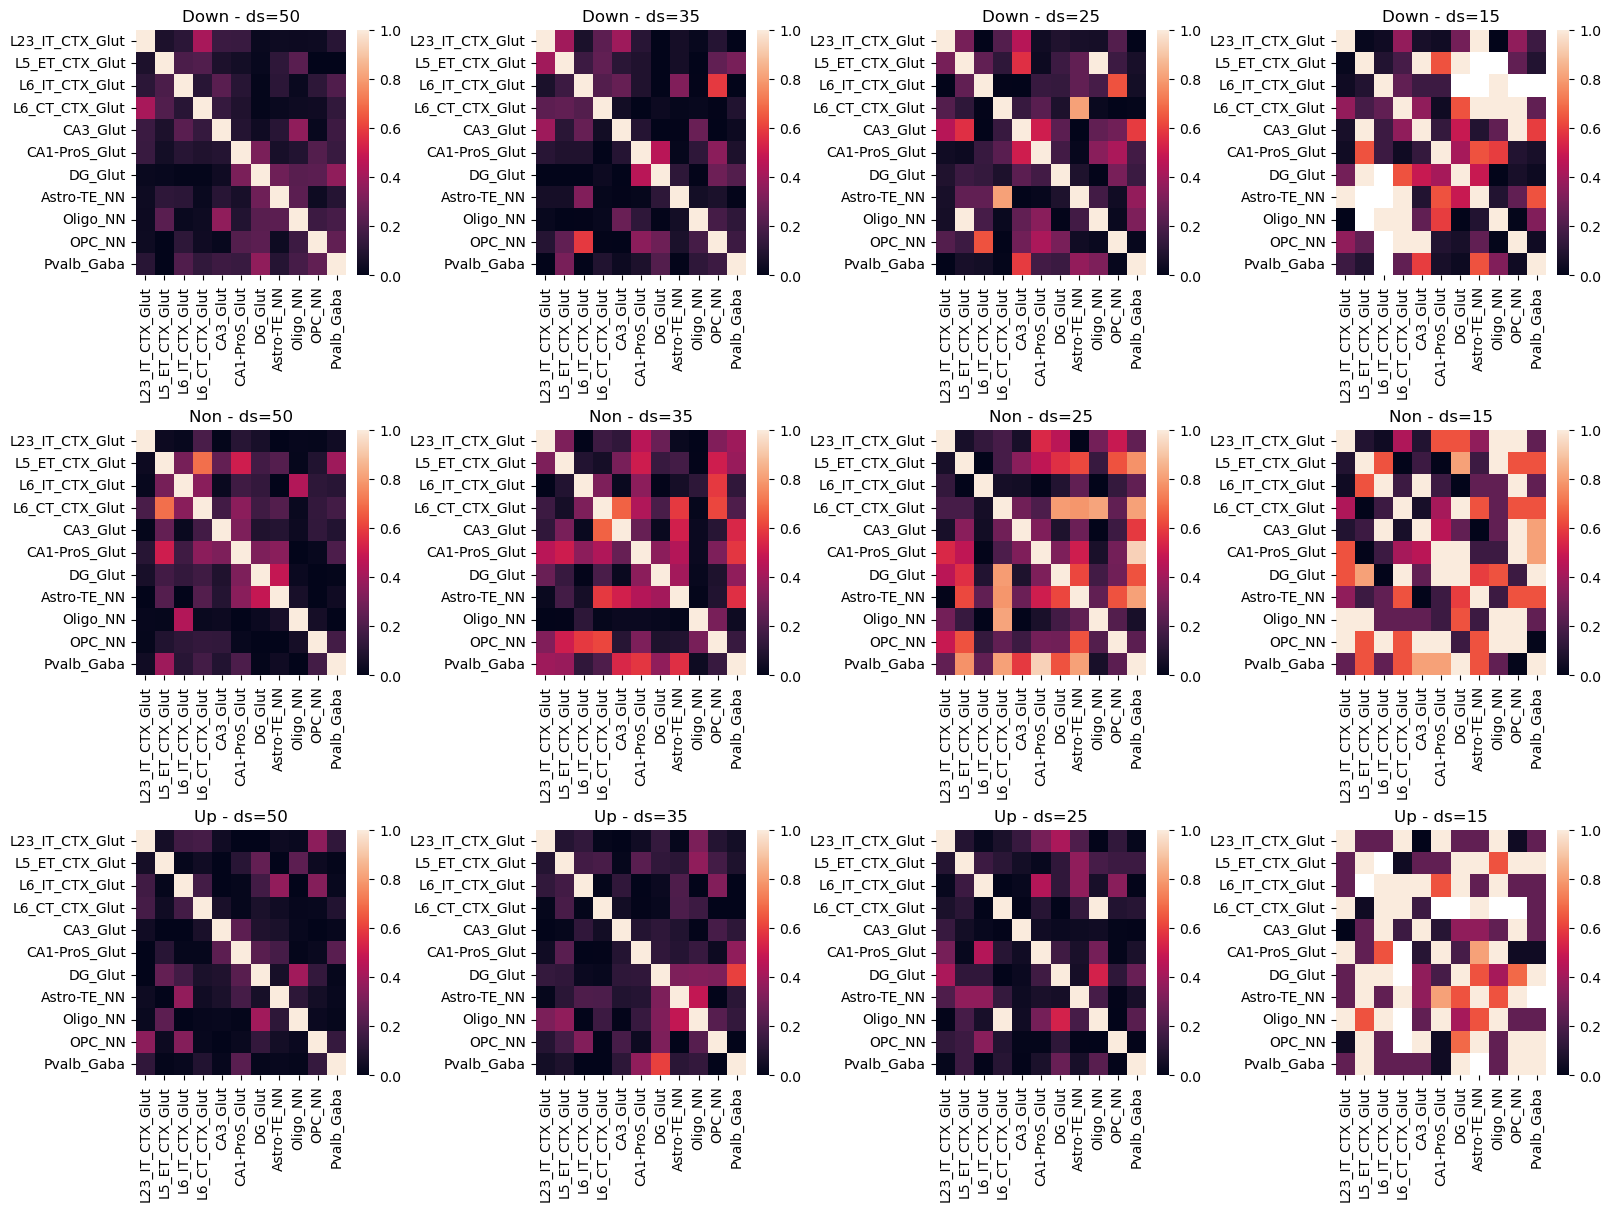

In [190]:
col = 'abs_mean_shap'
corr_method = 'pearson'

col = 'rank'
corr_method = 'spearman'

power = 2

ds_range = [50, 35, 25, 15]
fig, axes = plt.subplots(3, 4, figsize=(16, 12), constrained_layout=True)
for i, ds in enumerate(ds_range): 
    df_down, df_non, df_up = generate_rank_corr_matrix(cell_types, col=col, num_downsample=ds)
    
    tt = df_down.corr(method=corr_method).values
    tt = np.power(tt, power)
    sns.heatmap(tt, vmin=0, vmax=1, xticklabels=cell_types, yticklabels=cell_types, ax=axes[0][i])
    axes[0][i].set_title(f"Down - ds={ds}")
    
    tt = df_non.corr(method=corr_method).values
    tt = np.power(tt, power)
    sns.heatmap(tt, vmin=0, vmax=1, xticklabels=cell_types, yticklabels=cell_types, ax=axes[1][i])
    axes[1][i].set_title(f"Non - ds={ds}")
    
    tt = df_up.corr(method=corr_method).values
    tt = np.power(tt, power)
    sns.heatmap(tt, vmin=0, vmax=1, xticklabels=cell_types, yticklabels=cell_types, ax=axes[2][i])
    axes[2][i].set_title(f"Up - ds={ds}")

plt.show()

In [113]:
df_down, df_non, df_up = generate_rank_corr_matrix(cell_types, col=col, num_downsample=10)

In [119]:
features = df_down.index.union(df_non.index).union(df_up.index)

In [120]:
features

Index(['18mo.2mo.Q.mean.loops', '18mo.2mo.Q.median.loops',
       '18mo.2mo.Q.min.loops', '18mo.2mo.Q.std.loops', '18mo.2mo.T.max.loops',
       '18mo.2mo.T.median.loops', '18mo.2mo.T.min.loops',
       '18mo.2mo.T.std.loops',
       '18mo.2mo.activity.log_ratio.count.0-10kb.enhancer_peak',
       '18mo.2mo.activity.log_ratio.count.20kb-1Mb.enhancer_DMR',
       '18mo.2mo.activity.log_ratio.max.20kb-1Mb.enhancer_peak',
       '18mo.2mo.activity.log_ratio.mean.20kb-1Mb.enhancer_DMR',
       '18mo.2mo.activity.log_ratio.mean.20kb-1Mb.enhancer_peak',
       '18mo.2mo.activity.log_ratio.median.20kb-1Mb.enhancer_peak',
       '18mo.2mo.activity.log_ratio.min.20kb-1Mb.enhancer_peak',
       '18mo.2mo.activity.log_ratio.std.20kb-1Mb.enhancer_peak',
       '18mo.2mo.contact.log_ratio.mean.20kb-1Mb.enhancer_peak',
       '18mo.2mo.contact.log_ratio.min.20kb-1Mb.enhancer_peak',
       '18mo.2mo.contact.log_ratio.std.20kb-1Mb.enhancer_peak',
       '18mo.2mo.log_ratio.DAR', '18mo.2mo.log_ratio.DM

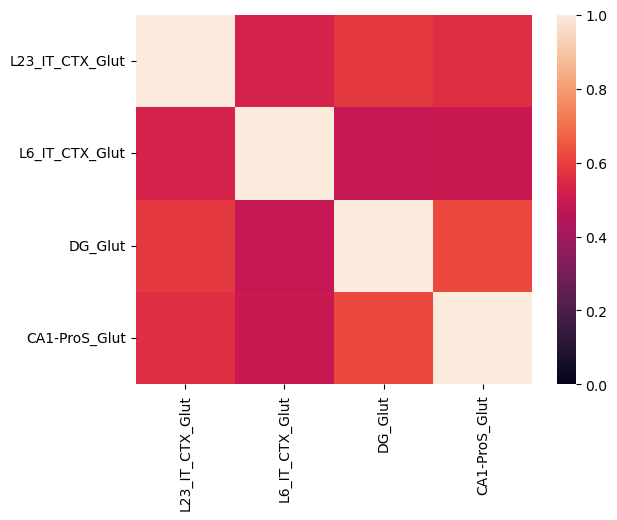

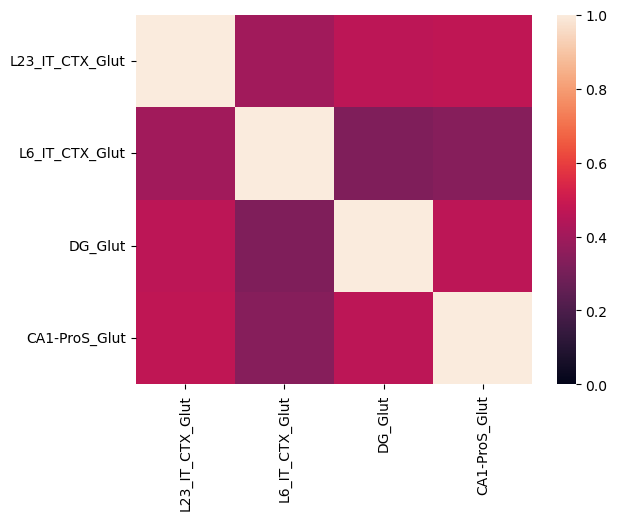

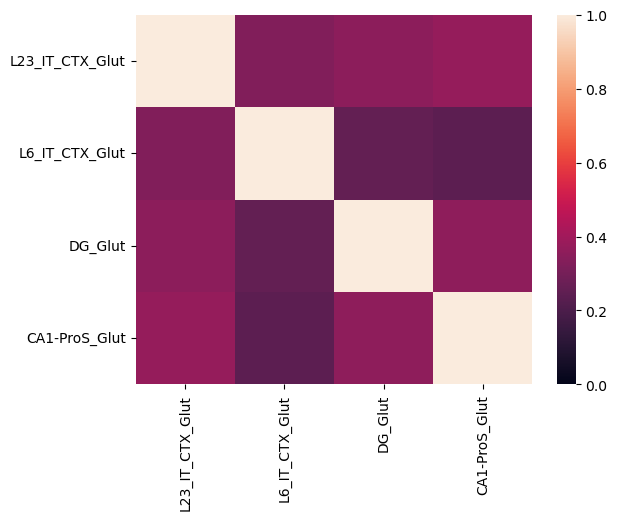

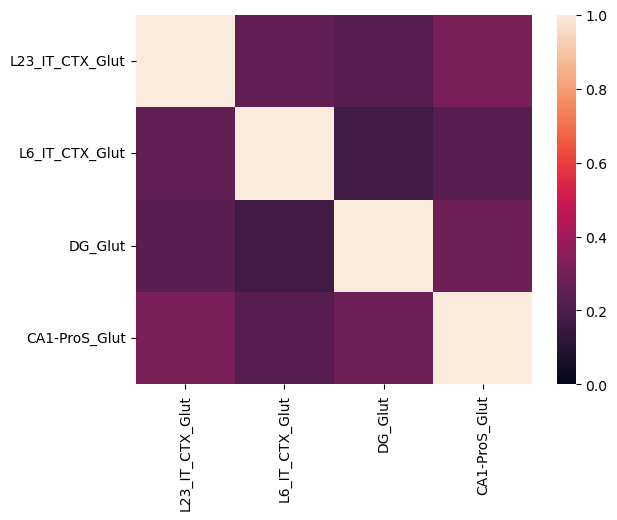

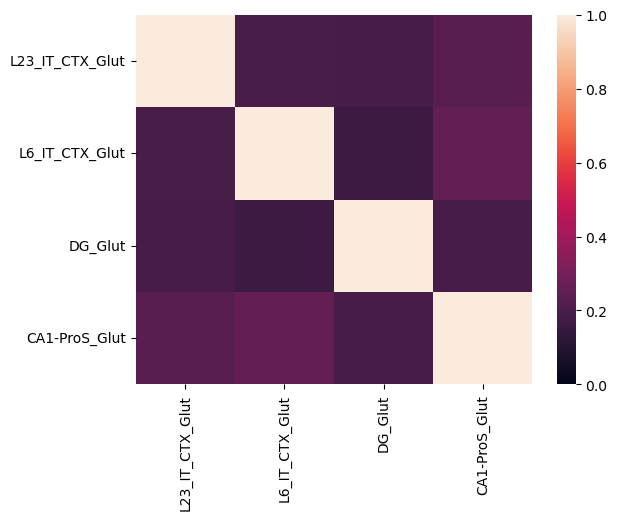

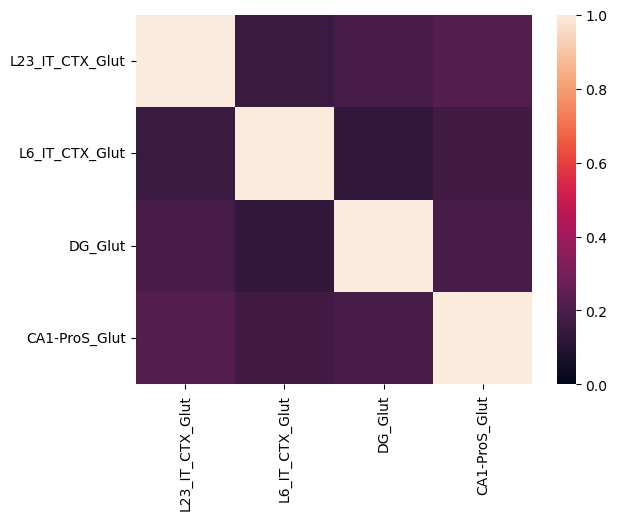

In [93]:
for _e in range(1, 7): 
    ctks = []
    for _ct in cell_types: 
        _, _, _, _, ctk_0 = read_json(_ct,  _e)
        ctks.append(ctk_0)
    # np.corrcoef(ctk_0, ctk_1)
    corr = jaccard_corr_matrix(ctks)
    sns.heatmap(corr, vmin = 0, vmax = 1, xticklabels=cell_types, yticklabels=cell_types)
    plt.show()
    # print(jaccard_similarity(ctk_0, ctk_1))
        

In [58]:
ctk_s = [ctk_0, ctk_1, ctk_0]

In [59]:
for i, x in enumerate(combinations(ctk_s, 2)): 
    print(i)

0
1
2


In [26]:
ccf = confusion_matrix(y_test_labels, y_test_preds)
ccf.sum(axis=0)

array([825, 670, 376])

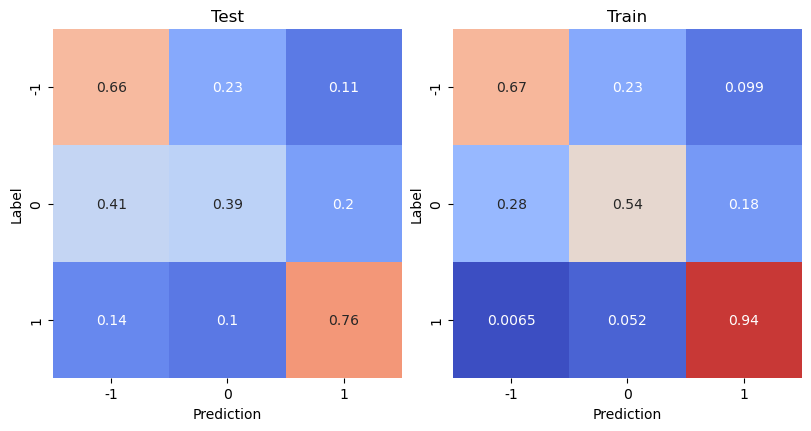

In [27]:
ccf_test = confusion_matrix(y_test_labels, y_test_preds, normalize='true')
ccf_train = confusion_matrix(y_train_labels, y_train_preds, normalize='true')
fig, ax = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)
sns.heatmap(ccf_test, vmin=0, vmax=1, xticklabels = ['-1', '0', '1'], yticklabels = ['-1', '0', '1'], 
            square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax[0])
sns.heatmap(ccf_train, vmin=0, vmax=1, xticklabels = ['-1', '0', '1'], yticklabels = ['-1', '0', '1'], 
            square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax[1])

ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Label")
ax[0].set_title("Test")
ax[1].set_xlabel("Prediction")
ax[1].set_ylabel("Label")
ax[1].set_title("Train")
plt.show()

In [28]:
max_gain = information_gain(y_test_labels, y_test_labels)
gain_ratio = information_gain(y_test_labels, y_test_preds) / max_gain
print("Information Gain Ratio: %.4f bits" % (gain_ratio))

Information Gain Ratio: 0.0647 bits
